## Download logs

In [1]:
pwd

'/home/arapat/Dropbox/workspace/research/rust-boost/notebooks'

In [2]:
%%sh

pushd ../logs-analysis/local/
wget https://www.dropbox.com/s/vs39sim5r1sc9d0/local-logs.tar?dl=0 -O logs.tar
tar -xf logs.tar
ls
popd

~/workspace/research/rust-boost/logs-analysis/local ~/workspace/research/rust-boost/notebooks
data-backup
logs.tar
run0
run1
run2
run3
run4
run5
run6
run7
setup.sh
~/workspace/research/rust-boost/notebooks


--2018-04-08 12:06:43--  https://www.dropbox.com/s/vs39sim5r1sc9d0/local-logs.tar?dl=0
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.1, 2620:100:6017:1::a27d:201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/XVPK1hwgwsqkARQE0Ne7AS9qjc8JlP7oNGJf8JBnIoKXFj1I3B0IR8IUAtu3qPYY/file [following]
--2018-04-08 12:06:44--  https://dl.dropboxusercontent.com/content_link/XVPK1hwgwsqkARQE0Ne7AS9qjc8JlP7oNGJf8JBnIoKXFj1I3B0IR8IUAtu3qPYY/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.6, 2620:100:6017:6::a27d:206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12369920 (12M) [application/x-tar]
Saving to: ‘logs.tar’

     0K .......... .......... ..........

## Parse data to pandas

In [3]:
%matplotlib inline

In [4]:
from io import StringIO
import csv
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [5]:
def create_dataframe(csv_string, col_names):
    return pd.read_csv(StringIO(csv_string), sep=",(?![^{]*\})", quoting=csv.QUOTE_ALL,
                       names=col_names, header=None)


def filter_logs(csv_file, keyword):
    with open(csv_file) as f:
        return ''.join([line for line in f if keyword in line]).strip()


def get_new_tree_info(log_file):
    logs = filter_logs(log_file, "new-tree-info")

    # Wrap tree in quotation marks
    parsed = []
    for line in logs.split('\n'):
        line = line.split(',', 7)
        line[-1] = '"{}"'.format(line[-1])
        parsed.append(', '.join(line))
    logs = '\n'.join(parsed)

    cols = ["level", "time", "module", "log-type",
            "tree-id", "num-scanned", "gamma", "tree"]
    return create_dataframe(logs, cols)


def get_performance(log_file):
    logs0 = filter_logs(log_file, "global_speed")
    logs1 = filter_logs(log_file, "learner_spped")
    # logs = filter_logs(log_file, "boosting_speed")

    parsed = []
    for line0, line1 in zip(logs0.split('\n'), logs1.split('\n')):
        line = line0 + ', ' + ', '.join(line1.rsplit(',', 3)[-3:])
        parsed.append(line)
    logs = '\n'.join(parsed)

    cols = ["level", "time", "module", "log-type",
            "overall-duration", "overall-count", "overall-speed",
            "learner-duration", "learner-count", "learner-speed"]
    return create_dataframe(logs, cols)


def get_true_z(log_file):
    logs = filter_logs(log_file, "validate-only")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "true-z", "auprc"]
    return create_dataframe(logs, cols)

In [6]:
trees = []
speed = []
true_z = []

range_size = [564, 464, 364, 264, 164, 64, 44, 24]
for i in range(8):
    _trees = get_new_tree_info("../logs-analysis/local/run%d/run-%d.log" % (i, i))
    _trees["estimated-z"] = np.exp(-(_trees["gamma"]**2).cumsum())
    _trees["range"] = range_size[i]
    trees.append(_trees)
    _speed = get_performance("../logs-analysis/local/run%d/run-%d.log" % (i, i))
    _speed["range"] = range_size[i]
    speed.append(_speed)
    _true_z = get_true_z("../logs-analysis/local/run%d/validate.log" % i)
    _true_z["range"] = range_size[i]
    true_z.append(_true_z)

trees = pd.concat(trees)
speed = pd.concat(speed)
true_z = pd.concat(true_z)

trees = trees.drop(columns=["level", "module", "log-type", "tree"])
true_z = true_z.drop(columns=["level", "module", "log-type", "time"])
speed = speed.drop(columns=["level", "module", "log-type"])

In [7]:
tree_info = trees.merge(true_z, on=["tree-id", "range"], how="outer")
tree_info.head()

,time,tree-id,num-scanned,gamma,estimated-z,range,true-z,auprc
0,497068.810703,1,10000,0.496800,0.781289,564,0.111952,0.006288
1,497264.414499,2,345000,0.164025,0.760549,564,NaN,NaN
2,497288.188954,3,44000,0.119574,0.749752,564,NaN,NaN
3,497297.189503,4,150000,0.107617,0.741119,564,NaN,NaN
4,497297.464755,5,35000,0.107617,0.732586,564,NaN,NaN


In [8]:
tree_info_by_id = tree_info.set_index("tree-id")
tree_info_by_time = tree_info.set_index("time")

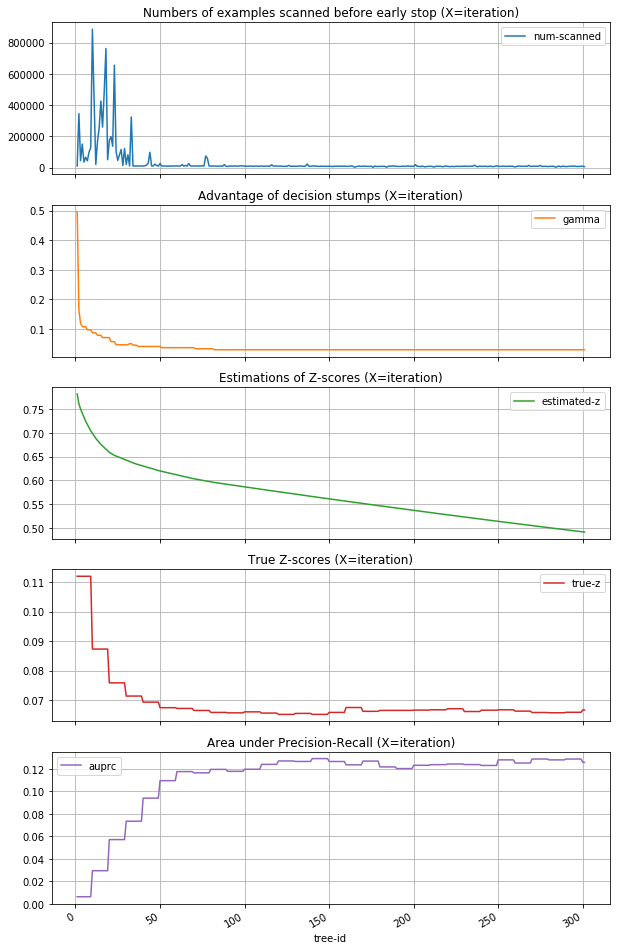

In [9]:
tree_info_by_id[tree_info_by_id["range"] == 564] \
    .drop(columns=["range", "time"]).fillna(method="pad").plot(
        subplots=True, figsize=(10, 18), grid=True,
        title=[
            "Numbers of examples scanned before early stop (X=iteration)",
            "Advantage of decision stumps (X=iteration)",
            "Estimations of Z-scores (X=iteration)",
            "True Z-scores (X=iteration)",
            "Area under Precision-Recall (X=iteration)"
        ]
    );

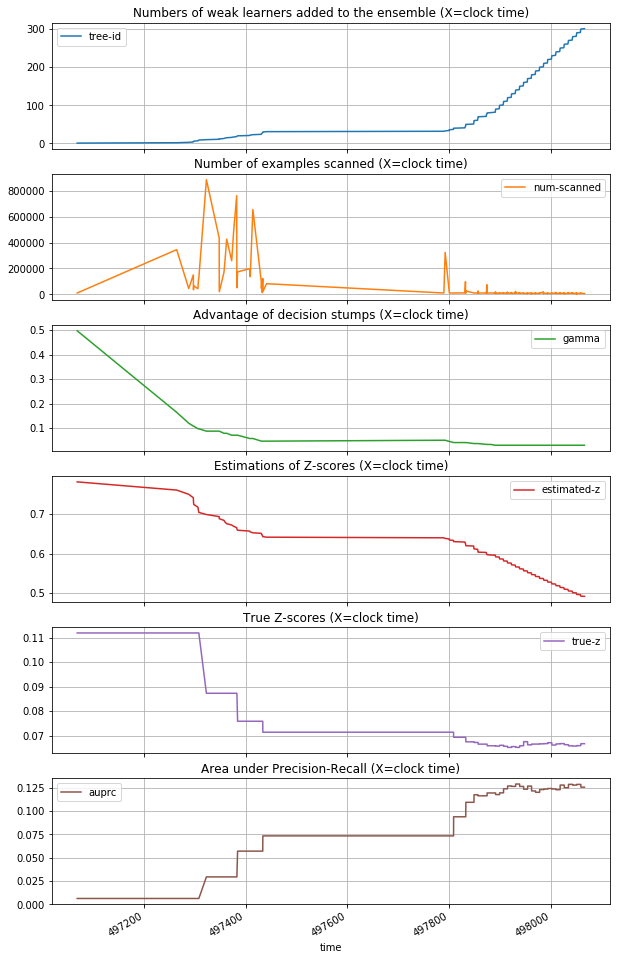

In [10]:
tree_info_by_time[tree_info_by_time["range"] == 564] \
    .drop(columns=["range"]).fillna(method="pad").plot(
        subplots=True, figsize=(10, 18), grid=True,
        title=[
            "Numbers of weak learners added to the ensemble (X=clock time)",
            "Number of examples scanned (X=clock time)",
            "Advantage of decision stumps (X=clock time)",
            "Estimations of Z-scores (X=clock time)",
            "True Z-scores (X=clock time)",
            "Area under Precision-Recall (X=clock time)"
        ]
    );

In [11]:
speed = speed.drop(
    columns=["overall-speed", "learner-speed"]
)
speed.head()

,time,overall-duration,overall-count,learner-duration,learner-count,range
0,497240.656864,10.001000,1286000,7.732000,1286000,564
1,497250.658245,20.002000,2569938,15.472001,2569938,564
2,497260.664418,30.009000,3861938,23.225000,3861938,564
3,497270.664736,40.009003,5144876,30.923002,5144876,564
4,497280.671261,50.015003,6426876,38.616000,6426876,564


# Cost of resampling

In the following plot, we can see two measures of the number of examples scanned as a function of the clock time:

1. `overall-count`: the total number of examples read from disk, which is the sum of the numbers of
examples scanned for the purpose of resampling and for the purpose of learning the weak rule,
2. `learner-count`: the number of examples read for the purpose of finding the new weak rule.

The difference bewteen `overall-count` and `learner-count` is the number of examples scanned for
re-sampling. In this version of the program we don't have the stratified sampling implemented,
so it takes a full scan of the entire training data set to generate a new sample.

As it shows in the plot, re-sampling consumes examples at a faster rate than finding a new weak rule,
but still takes a significant amount of time.

It is strange that the rate at which the learner consume examples to find new weak rules is not constant. I need to look into it.

In [12]:
from matplotlib import pyplot as plt

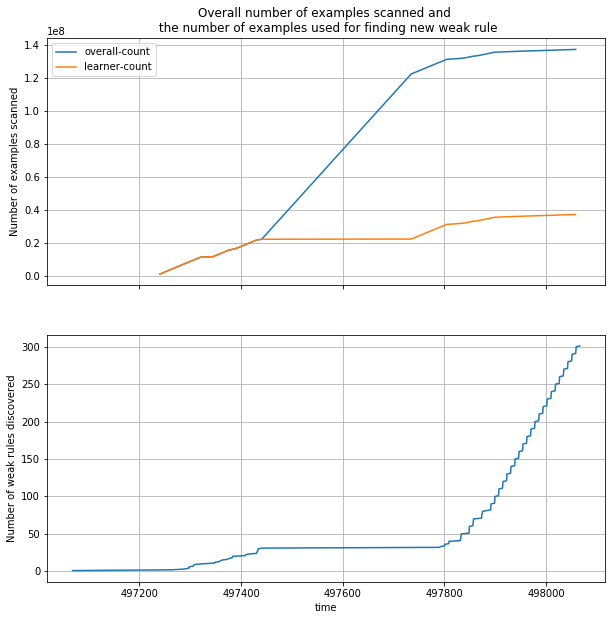

In [13]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(211)

ranges = sorted(speed["range"].unique(), reverse=True)
# .drop(columns=["overall-duration", "learner-duration"])
speed[speed["range"] == ranges[0]].plot(
    x="time", y="overall-count",
    ax=ax1
)
speed[speed["range"] == ranges[0]].plot(
    x="time", y="learner-count",
    grid=True,
    title = "Overall number of examples scanned and \n the number of examples "
            "used for finding new weak rule",
    ax=ax1
)
ax1.set_ylabel("Number of examples scanned");

# plt.figure(figsize=(10, 6))
ax2 = plt.subplot(212, sharex=ax1)
tree_info_by_time[tree_info_by_time["range"] == 564] \
    .drop(columns=["range"]).fillna(method="pad")["tree-id"].plot(
        grid=True, ax=ax2
    )
ax2.set_ylabel("Number of weak rules discovered");

# Reading speed as a function of feature sizes

Following plots show the rates at which the algorithm consumes examples for different feature sizes. The purpose is showing that when the feature size is small enough to fit in the CPU caches, there should be a jump in the performance measured by the numbers of examples being consumed.

From the plot, it is possible that the input size is optimized for CPU caches when the feature size is 64 (see the gap between the line denoting feature size being 164 and the line denoting feature size being 64).

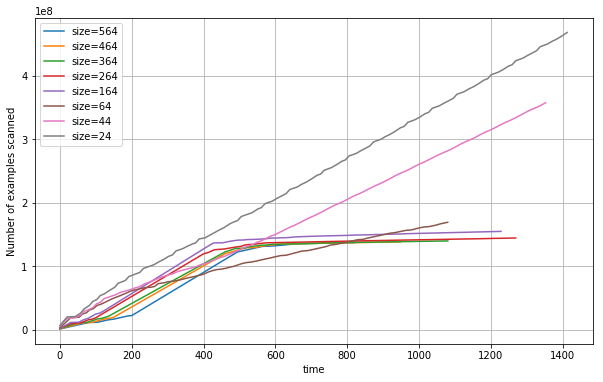

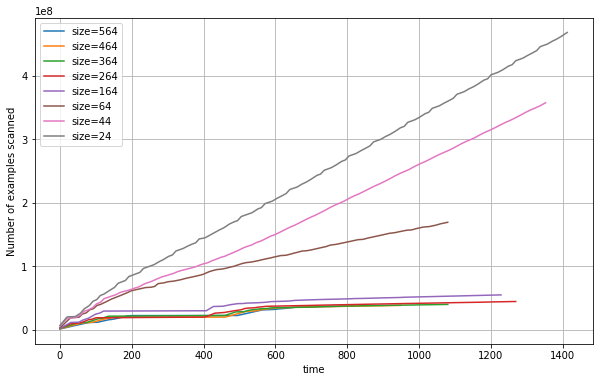

In [14]:
def plot_different_feature_size(keyword):
    ranges = sorted(speed["range"].unique(), reverse=True)
    overall = pd.concat([
        speed[speed["range"] == ranges[0]]["time"] - \
            speed[speed["range"] == ranges[0]]["time"].iloc[0],
        speed[speed["range"] == ranges[0]][keyword]
    ], axis=1)
    ax = overall.plot(
        x="time", y=keyword, label="size=564",
        figsize=(10, 6), grid=True
    )
    for k in ranges[1:]:
        overall = pd.concat([
            speed[speed["range"] == k]["time"] - \
                speed[speed["range"] == k]["time"].iloc[0],
            speed[speed["range"] == k][keyword]
        ], axis=1)
        overall.plot(
            x="time", y=keyword, label="size=%d" % k,
            ax=ax, grid=True
        )
    # ax.set_xlim(0, 100)
    # ax.set_ylim(0, 0.4e8)
    ax.set_ylabel("Number of examples scanned");


plot_different_feature_size("overall-count")
plot_different_feature_size("learner-count")